# head study

In [81]:
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
epoch(13000,"mjd2000"), epoch(15000,"mjd2000")

(2035-Aug-05 00:00:00, 2041-Jan-25 00:00:00)

In [83]:
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "spk", "de440.bsp"))
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "lsk", "naif0012.tls"))

In [89]:
MU_VENUS = 3.2485859200000006E+05*1e9   # in SI
MU_JUPITER = 1.2671276480000021E+08 * 1e9  # in SI
MU_SATURN = 3.7940585200000003E+07*1e9  # in SI

R_VENUS  = 12104/2 * 1e3
R_EARTH  = 6378 *1e3
R_JUPITER = 142984.0 / 2 * 1e3
R_SATURN = 120536.0 / 2 * 1e3

In [90]:
venus = pk.planet.spice('2', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, MU_JUPITER, R_VENUS, R_VENUS * 1.05)
earth = pk.planet.spice('3', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, pk.MU_EARTH, R_EARTH, R_EARTH * 1.05)
jupiter = pk.planet.spice('5', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, MU_JUPITER, R_JUPITER, R_JUPITER * 1.05)
saturn = pk.planet.spice('6', 'SUN', 'ECLIPJ2000', 'NONE', pk.MU_SUN, MU_SATURN, R_SATURN, R_SATURN * 1.05)

# test
r,v = saturn.eph(pk.epoch(9500))

In [116]:
#seq = [jpl_lp('earth'), jpl_lp('venus'), jpl_lp('earth'), jpl_lp('saturn')]
seq = [earth, earth, saturn]

# prob_return = pk.trajopt.mga_1dsm(
#     seq = seq,
#     t0 = [
#         epoch(12000,"mjd2000"),
#         epoch(13000,"mjd2000"),
#         #pk.epoch_from_string('2020-01-20 23:59:54.003').mjd,
#         #pk.epoch_from_string('2030-01-20 23:59:54.003').mjd
#     ], 
#     tof = [
#         [2/pk.DAY2YEAR, 6/pk.DAY2YEAR],
#         [3/pk.DAY2YEAR, 6/pk.DAY2YEAR],
#     ], 
#     vinf = [0.0, 0.0], 
#     multi_objective = False, 
#     add_vinf_dep = True, 
#     add_vinf_arr = False,
#     tof_encoding = 'direct'
# )

In [117]:
# prob_return.fitness(pop.champion_x)

In [118]:
# algo = pg.algorithm(pg.sade(gen=4000))

In [119]:
# print("Evolving...")
# pop = pg.population(prob=prob_return, size=30)
# pop = algo.evolve(pop)
# print("Done!")

In [120]:
def iterate_launch_windows(seq, t0, tof):
    prob_iter = pk.trajopt.mga_1dsm(
        seq = seq,
        t0 = t0,
        tof=tof,
        vinf = [0.0, 3.0], 
        multi_objective = False, 
        add_vinf_dep = False, 
        add_vinf_arr = True,
        tof_encoding = 'direct'
    )
    pop = pg.population(prob=prob_iter, size=20)
    algo = pg.algorithm(pg.sade(gen=1000))
    pop = algo.evolve(pop)
    return prob_iter, pop

In [121]:
epoch(9000+i_window*100,"mjd2000")

2038-Jan-21 00:00:00

In [151]:
tof = [
    [2/pk.DAY2YEAR, 10/pk.DAY2YEAR],
    [3/pk.DAY2YEAR, 10/pk.DAY2YEAR],
    #[3/pk.DAY2YEAR, 7/pk.DAY2YEAR],
]

prop_list = []
pop_list = []

for i_window in tqdm(range(50)):
    t0_iter = [
        epoch(8000+i_window*100,"mjd2000"),
        epoch(8000+(i_window+1)*100,"mjd2000"),
    ]
    #try:
    prob_iter, pop = iterate_launch_windows(seq, t0_iter, tof)
    pop_list.append(pop)
    prop_list.append(prob_iter)
#     except:
#         print(f"Failed in {i_window}")
#         pass

  0%|          | 0/50 [00:00<?, ?it/s]

In [138]:
# get combined list of xs and fs
for idx,pop_iter in enumerate(pop_list):
    if idx == 0:
        x_combined = pop_iter.get_x()
        f_combined = pop_iter.get_f()
    else:
        x_combined = np.concatenate((x_combined, pop_iter.get_x()),axis=0)
        f_combined = np.concatenate((f_combined, pop_iter.get_f()))

In [139]:
x_combined.shape

(1000, 10)

In [140]:
np.argmin(f_combined)

987

In [141]:
xbest = x_combined[np.argmin(f_combined),:]

In [142]:
#prob_return.pretty(xbest)

In [130]:
# pretty_outside(prob_return, pop.champion_x)

```
direct encoding: [t0] + [u, v, Vinf, eta1, T1] + [beta, rp/rV, eta2, T2] + ... 
```

In [143]:
def porkchop_process(pop_x, pop_f):
    # extract from decision vector
    data = {
        "t0": [],
        "tof_total": [],
        "f": []
    }
    for idx, x in enumerate(pop_x):
        data["t0"].append(x[0])
        # get tof
        tof_total = x[5]
        for i_leg in range(len(seq)-2):
            tof_total += x[5+4*(i_leg+1)]
        data["tof_total"].append(tof_total)
        # objective
        data["f"].append(pop_f[idx])
    # convert to numpy array
    data["t0"] = np.array(data["t0"])
    data["tof_total"] = np.array(data["tof_total"])
    data["f"] = np.array(data["f"])
    return data

In [144]:
porkchop_return = porkchop_process(x_combined, f_combined)
#porkchop_return = porkchop_process(pop.get_x(), pop.get_f())

In [146]:
seq_name = ""
for se in seq:
    seq_name += se.name + "-"
seq_name = seq_name[:-1]
seq_name

'3, SUN, ECLIPJ2000-3, SUN, ECLIPJ2000-6, SUN, ECLIPJ2000'

In [148]:
seq_name = "Earth-Earth-Saturn"

<IPython.core.display.Javascript object>


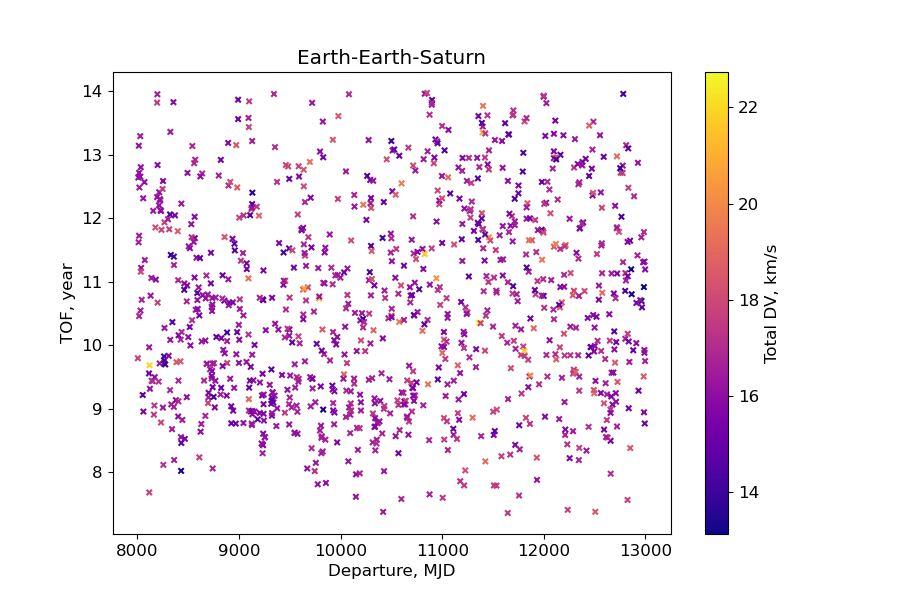

In [149]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1,1,figsize=(9,6))

im0 = ax.scatter(porkchop_return['t0'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['f']/1e3, cmap='plasma', s=15, marker='x')

fig.colorbar(im0, label='Total DV, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure, MJD", ylabel="TOF, year")

plt.show()

In [150]:
fig.savefig("./plots/head_pc_"+seq_name+".png")

In [187]:
# prob_return.plot(pop.champion_x)
# plt.show()